In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# **Reusable Launch System of a Rocket**

Reusing a **Stage** of a Multistage Rocket can drastically reduce the cost. To achieve this, it is necessary to safely land and recover the system.<br>
The figure below displays the simple system of Rocket Stage on approach and the relevant parameters.

<img src="rocket.png" alt="Rocket Landing" width="500" height="500"> <br>
|**Symbol**  |**Definition**                   |**SI System of Units** |
|------------|---------------------------------|-----------------------|
|$h(t)$      |Altitude                         |[m]                    |
|$\theta(t)$ |Inclination of the Stage         |[rad]                  |
|$\phi(t)$   |Thrust angle of the Engine       |[rad]                  |
|$F_t$       |Maximum Thrust of the Engine     |[N]                    |
|$g$         |Gravitational Acceleration       |$\text{ms}^{-2}$|      |
|$l_s$       |Distance from the centre of mass |[m]                    |
|$l_t$       |Length of the Engine             |[m]                    |
|$m$         |Total mass                       |[kg]                   |
|$J$         |Moment of inertia                |$\text{kgm}^{2}$       |

***Assumption:*** For a safe landing at a height $h=0 m$, both vertical inclination $\theta$ being equal to 0° and a low vertical velocity $\dot{h}$ are necessary. The inclination $\theta$ can be adjusted by aligning the engine to an angle $\phi$.

The stage, with a mass of $m$, is powered by an engine providing a thrust $F_t$. The moment of inertia around the centre of mass is $J$, with the distance form the centre of mass to the lower end of the rocket stage being $l_s$. The engine itself is $l_t$ high.

We now sketch Mass-Acceleration and Free Body Diagrams to find the equations. For the sake of aimplicity, we only consider the vertical direction of the forces with the positive direction pointing upwards and the torque with the positive direction being counterclockwise in the plane.<br>

<img src="mad.png" alt="MAD" width="500" height="500">
<img src="fbd.png" alt="FBD" width="500" height="500">

Under the neglection of aerodynamic effects, we can form these equations with the aid of Newton's laws of motion

$m \cdot \ddot{h}(t) = \sum F_{vertical} = F_t \cdot \cos(\phi(t) + \theta(t)) - m \cdot g$

$J \cdot \ddot{\theta}(t) = \sum M^{\text{centre of mass}} = -F_t \cdot \sin(\phi(t)) \cdot (l_s + \cos((\phi(t)) \cdot l_t))$


To find the initial velocities of the stage, we appyly the conservation of energy principle at the times when it has been seperated and starts to freefalf and when it is reignited

$E_{total} = K_{reignition} + U_{reignition} = K_{freefall} + U_{freefall} = const$
<br>
where:
* Kinetic energy: $K = \frac {1}{2} m \dot{h}^2$
* Potential energy: $U = mgh$

$\frac {1}{2} m \dot{h}_{reignition}^2 + mgh_{reignition} = \frac {1}{2} m \dot{h}_{freefall}^2 + mgh_{freefall}$

with $\dot{h}_{freefall} = 0 ms^{-1}, \quad h_{freefall} = 80000m$. For the sake of simplicity are the physical and aerospacial effects neglected, we yield the equation

$\frac {\dot{h}_{reignition}^2}{2} = g(h_{freefall} - h_{reignition})$

$\dot{h}_{reignition} = \sqrt{2 \cdot g(h_{freefall} - h_{reignition})}$


This problem, which involves dynamic motion, inclination, and thrust controll of a rocket stage, can be considered as an *Initial Value Problem (IVP)* where we typically employ numerical methods for solving ordinary differential equations (ODEs) or optimal control techniques. 

For instance, let us now use the parameters of the first (booster) stage of Falcon 9 Full Thrust designed and manufactured in the United States by SpaceX, which has its historic landing at CCSFS Landing Zone 1, 22 December 2015. This is the first successful attempt to land a rocket stage in aerospace history. The stage is provided with following details:

$F_t \approx 7607 kN = 7.607 \cdot 10^6 N, \quad m \approx 35 t = 35 \cdot 10^3 kg$

$l_s \approx 19 m, \quad l_t \approx 2.9 m$ 

$J \approx \frac {1}{12}mL^2 = \frac {1}{12} \cdot 35000kg \cdot (42.6m)^2 = 5.293 \cdot 10^6 kgm^2,$

$\text{with } L = 42.6m$ is the length of the stage, assuming that it has a cylindrical shape


In [15]:
m = 35000   # Mass in kg
Ft = 7607000   # Thrust in N
g = 9.81   # Gravity in m/s^2
J = 5293000  # Moment of inertia in kg·m^2
ls = 19   # Distance from CoM to bottom in m
lt = 2.9   # Engine length in m

In order to solve the ODE we employ the numerical explicit Runge-Kutta method of the fourth order for higher accuracy. The method is used to calculate the values of the system of functions at every infinitesimal time iteration using the found values of the previous step. 

In [16]:
def rk4(f, y, t, dt):
    y = np.array(y)

    # Butcher Tableau
    k1 = np.array(f(t,y))
    k2 = np.array(f(t + dt/2 , y + dt/2*k1))
    k3 = np.array(f(t + dt/2 , y + dt/2*k2))
    k4 = np.array(f(t + dt , y + dt*k3))

    y_next = y + dt * (1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)
    t_next = t + dt
    
    return t_next, y_next

Adjusting the thrust angle $\phi(t)$ over time is neccessary to achieve the enventual angular velocity being equal to zero, hence we need a suitable controller. In this case we use the PD controller since we can compute the derivative of error (which is $\dot{\theta}$). We choose the coefficients $K_p=30$ and $K_d=10$. Additionally $\phi$ is designed to strictly be in the range $[-15°,15°]$

In [17]:
def compute_phi(theta, theta_dot):
    Kp = 30
    Kd = 10
    phi = Kp * abs(theta) - Kd * abs(theta_dot)
    phi = np.clip(phi, np.deg2rad(-15), np.deg2rad(15))     # Clip phi to the interval edges when it goes beyond the interval
    return phi

We define the system of ODEs computing vertical and angular velocity as well as acceleration at each time step.

In [18]:
def stage_dynamics(t, y):
    h, h_dot, theta, theta_dot = y

    phi = compute_phi(theta, theta_dot)

    h_ddot = (Ft * np.cos(phi + theta) - m * g) / m
    theta_ddot = (-Ft * np.sin(phi) * (ls + lt * np.cos(phi))) / J

    return [h_dot, h_ddot, theta_dot, theta_ddot]

Let us declare the initial conditions of the problem.

In [ ]:
# Initial conditions
theta0 = np.radians(20)   # Initial inclination in radians
thetadot0 = 0   # Initial angular velocity in rad/s
def hdot0(h0):   # Function of vertical velocity at the time it is reignited, depends on initial altitude
    return -np.sqrt(2 * g * (80000 - h0))

t_0 = 0
t_end = 10   # Simulate the modell in 10 seconds


Employing the fourth-order Runge Kutta method with the step size of $0.01$, we find the states of motion of the stage. By the touchdown event, to get the precise landing altitude $h = 0$, we can approximate the time by using linear interpolation, which has the form

$\frac {t_{int}-t_n}{h_{int}-h_n} = \frac {t_{n+1}-t_n}{h_{n+1}-h_n}, \quad \text{ where }h_{int} = h_{end} = 0$

$t_{int} = t_n + (0 - h_n) \cdot \frac {t_{n+1}-t_n}{h_{n+1}-h_n}$

In [20]:
def stage_state_values(y0, t0, tend):
    t = [t0]
    y = [y0]
    while t[-1] < tend:
        t_next, y_next = rk4(stage_dynamics, y[-1], t[-1], 0.01)
        t.append(t_next)
        y.append(y_next)
        if y_next[0] <= 0:
            # Linear interpolation for better approximaition of zero crossing
            t_final = t[-2] + (0 - y[-2][0]) * (t[-1] - t[-2]) / (y[-1][0]  - y[-2][0])
            t[-1] = t_final     # Replace last time with interpolated value
            y[-1][0] = 0        # Set altitude to exact zero
            break
    y = np.array(y)
    
    return t, y

Our goal is to find out with which magnitude of $h_0$, the touchdown vertical velocity can be minimized so as not to cause any damage to the rocket stage. We define an objective function with a parameter of $h_0$.

In [24]:
def objective_function(h0):
    h0 = np.asarray(h0).item()
    y0 = np.array([h0, hdot0(h0), theta0, thetadot0])

    t, y = stage_state_values(y0, t_0, t_end)
    final_h = y[-1][0]
    final_hdot = y[-1][1]

    return final_h**2 + final_hdot**2   # Deviations from 0

Using *scipy.optimize.minimize()* function, we can find the optimal initial $h$ to get the smallest vertical velocity at touchown. 

In [ ]:
h0_initial_guess = 5000   # Initiate a random first guess for the modell

optimal_result = minimize(objective_function, h0_initial_guess, bounds=[(0, 80000)])   # Yield the optimal initial altitude
optimal_h0 = optimal_result.x[0]
optimal_y0 = np.array([optimal_h0, hdot0(optimal_h0), theta0, thetadot0])

t_values, optimal_y = stage_state_values(optimal_y0, t_0, t_end)

# Extract the results
h_values = optimal_y[:, 0]
hdot_values = optimal_y[:, 1]
theta_values = optimal_y[:, 2]
thetadot_values = optimal_y[:, 3]

print(f"At the time {t_values[-1]}sec after being reignited, the rocket stage approaches the ground h = {h_values[-1]} with the vertical velocity of {hdot_values[-1]} and the inclination of {theta_values[-1]}, which is eligible!")


At the time 5.929966945363675, the rocket stage approaches the ground h = 0.0 with the vertical velocity of -0.7223530170164976 and the inclination of 2.5777691332304936e-07, which is eligible!


Plot the figures for visualisation.

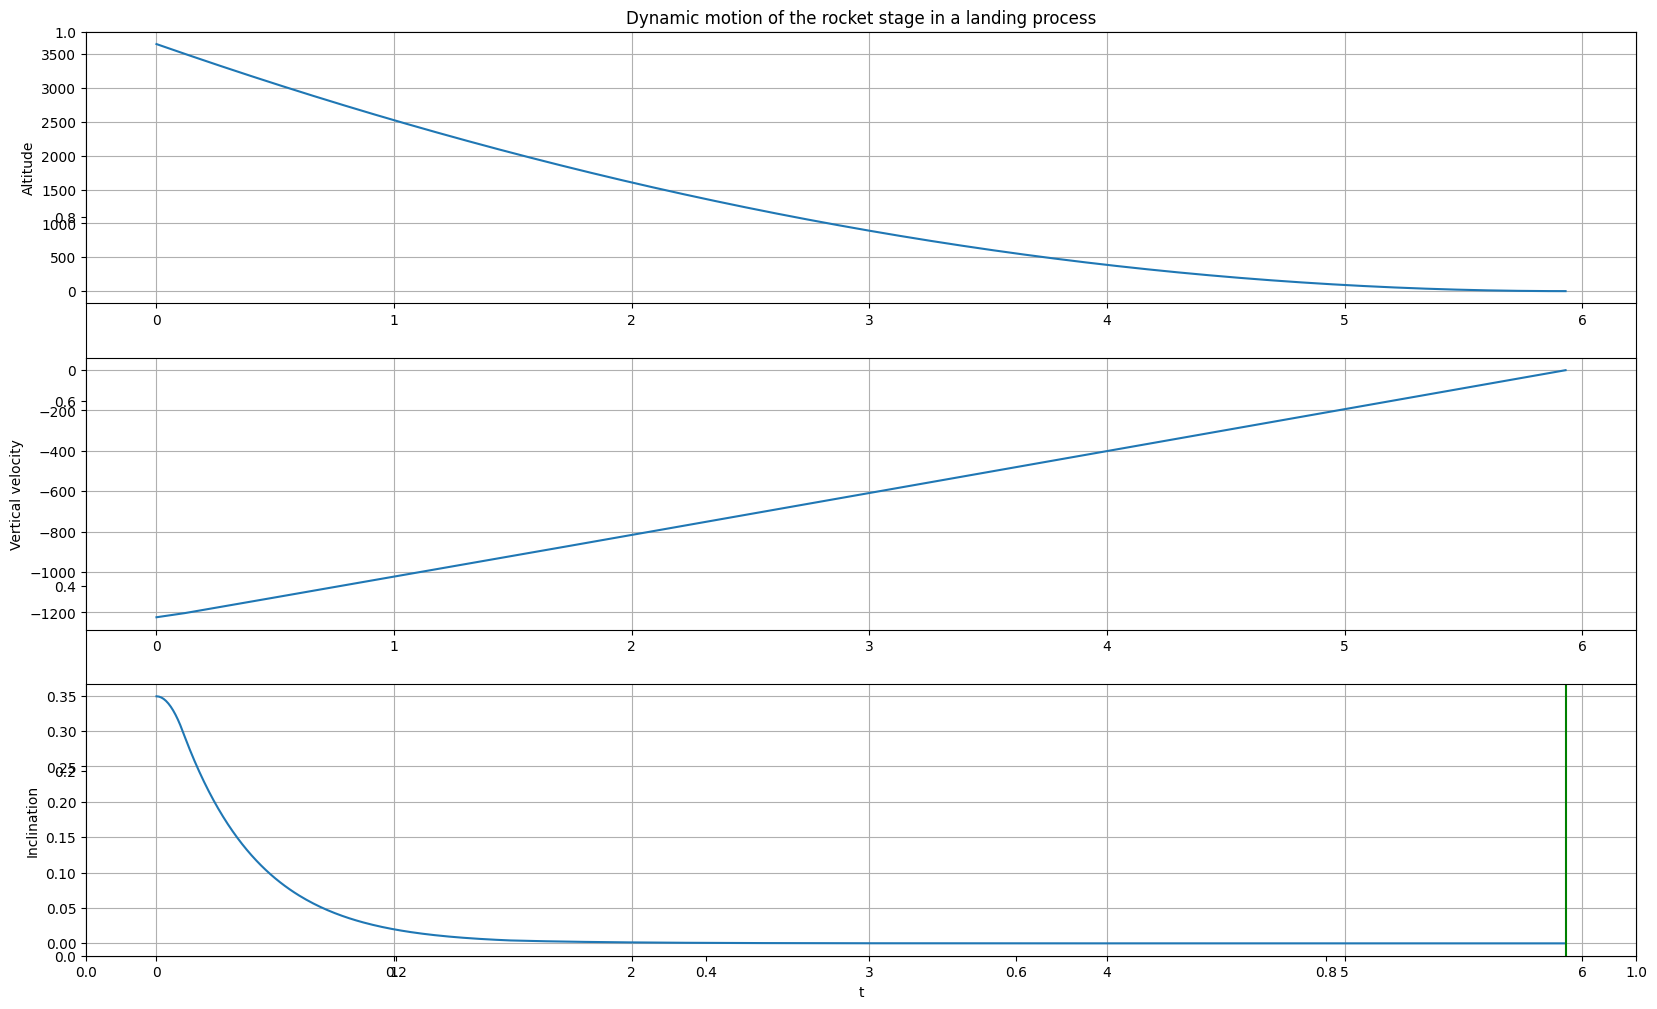

In [ ]:
plt.figure(figsize=(20,12))
plt.title('Dynamic motion of the rocket stage in a landing process')

plt.subplot(3, 1, 1)
plt.plot(t_values, h_values)
plt.ylabel('Altitude')
plt.grid(True)

plt.subplot(3,1, 2)
plt.plot(t_values, hdot_values)
plt.ylabel('Vertical velocity')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_values, theta_values)
plt.xlabel('t')
plt.ylabel('Inclination')
plt.grid(True)

plt.axvline(x = 5.929966945363675, color ='g', label = 'touchdown')
plt.legend()
plt.show()